In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 2
setup_one_gpu(GPU)

Picking GPU 2


In [2]:
from scipy.io import loadmat
from geo_tool import Point_Cloud
import matplotlib.pylab as plt
from scipy.spatial.distance import pdist
import numpy as np
import tensorflow as tf

In [3]:
from tflearn.layers.core import fully_connected
from tf_lab.point_clouds.encoders_decoders import encoder_with_convs_and_symmetry_new, decoder_with_fc_only
from tf_lab.data_sets.numpy_dataset import NumpyDataset

#from tf_lab.iclr.helper import load_multiple_version_of_pcs

In [4]:
%matplotlib inline

In [5]:
# LOAD Data
in_pc = '/orions4-zfs/projects/optas/DATA/OUT/latent_fmaps/pc_data.mat'
in_pc = loadmat(in_pc)['pc_data']

in_diffs = '/orions4-zfs/projects/optas/DATA/OUT/latent_fmaps/latent_diff_maps.mat'
diff_maps = loadmat(in_diffs)['N']

in_basis = '/orions4-zfs/projects/optas/DATA/OUT/latent_fmaps/basis.mat'
in_basis = loadmat(in_basis)['basis']

In [6]:
n_pc = in_pc.shape[0]
n_pc_points = in_pc.shape[1]
n_latent = int(np.sqrt(diff_maps.shape[1]))
diff_maps = diff_maps.reshape(-1, n_latent, n_latent)

# n_classes = n_pc
# labels = np.zeros((n_pc, n_classes))
# np.fill_diagonal(labels, np.ones(n_pc))

n_classes = 2
labels = np.zeros((n_pc, n_classes))
labels[:50, 0] = 1
labels[50:, 1] = 1

In [90]:
#pc = load_multiple_version_of_pcs('uniform_one', '03001627', True)
# in_pc = pc['train'].point_clouds[:100]
# n_pc_points = in_pc.shape[1]

In [7]:
train_data = NumpyDataset([in_pc, diff_maps, labels], ['pc', 'diff', 'label'])

['pc', 'diff', 'label']


In [8]:
in_points = tf.placeholder(tf.float32, shape=(None, n_pc_points, 3))
in_diffs = tf.placeholder(tf.float32, shape=(None, n_latent, n_latent))
in_labels = tf.placeholder(tf.float32, shape=[None, n_classes])

# z = encoder_with_convs_and_symmetry_new(in_points, n_filters=[64, 128, 128, 256], b_norm=False)

# d0 = fully_connected(z, n_latent, activation='linear', weights_init='xavier')

# d1 = tf.matmul(tf.expand_dims(d0, 1), in_diffs)

d0 = decoder_with_fc_only(in_diffs, layer_sizes=[100, 200, n_latent])
# d1 = tf.matmul(tf.expand_dims(d0, 1), in_diffs)

logits = fully_connected(d0, n_classes, activation='linear', weights_init='xavier')

prediction = tf.argmax(logits, axis=1)
target_ = tf.argmax(in_labels, axis=1)
correct_pred = tf.equal(prediction, target_)
avg_accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=in_labels)
loss = tf.reduce_mean(cross_entropy)

In [9]:
learning_rate = 0.001
opt = tf.train.AdamOptimizer(learning_rate)
opt_step = opt.minimize(loss)

In [10]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
init=tf.global_variables_initializer()
sess.run(init)

In [11]:
batch_size = 50
all_losses = []
for epochs in range(100):
    for _ in range(2):
        p, d, l = train_data.next_batch(batch_size)
        feed_dict = {in_points:p, in_diffs:d, in_labels:l}
        sess.run([opt_step, loss, avg_accuracy], feed_dict=feed_dict)
    
    feed_dict = {in_points:train_data.pc, in_diffs:train_data.diff, in_labels:train_data.label}
    all_losses.append(sess.run([avg_accuracy], feed_dict=feed_dict))
    print all_losses[-1]

[0.5]
[0.5]
[0.5]
[0.49999997]
[0.5]
[0.90999997]
[0.55999994]
[0.94]
[0.94999999]
[0.61999995]
[0.5]
[0.52999997]
[0.70999998]
[0.69999993]
[0.75999999]
[0.94999999]
[0.90999997]
[0.94999999]
[0.88]
[0.94]
[0.95000005]
[0.91999996]
[0.95999998]
[0.96000004]
[0.89000005]
[0.96999997]
[0.96000004]
[0.94]
[0.97000003]
[0.94999999]
[0.97000003]
[0.98000002]
[0.93999994]
[0.98000002]
[0.92000002]
[0.95000005]
[0.90999997]
[0.97999996]
[0.94999999]
[0.97000003]
[0.93999994]
[0.98999995]
[0.97999996]
[0.95000005]
[0.99000001]
[0.96999997]
[1.0]
[1.0]
[0.99999994]
[0.99999994]
[0.99999994]
[1.0]
[1.0]
[0.99999994]
[1.0]
[1.0]
[1.0]
[0.99999994]
[1.0]
[1.0]
[1.0]
[0.99999994]
[0.99999994]
[1.0]
[1.0]
[0.99999994]
[0.99999994]
[1.0]
[1.0]
[0.99999994]
[1.0]
[1.0]
[1.0]
[0.99999994]
[0.99999994]
[1.0]
[0.99999994]
[1.0]
[0.99999994]
[1.0]
[1.0]
[0.99999994]
[0.99999994]
[1.0]
[1.0]
[1.0]
[0.99999994]
[1.0]
[1.0]
[0.99999994]
[0.99999994]
[1.0]
[1.0]
[0.99999994]
[1.0]
[1.0]
[1.0]
[0.99999994]
[1

In [12]:
feed_dict = {in_points:in_pc, in_diffs:diff_maps, in_labels:labels}
highlights = sess.run(d0, feed_dict=feed_dict)
sess.run(avg_accuracy, feed_dict=feed_dict)
# np.savetxt('/orions4-zfs/projects/optas/DATA/OUT/latent_fmaps/highlights.txt', highlights)

1.0

In [13]:
colors = np.zeros(shape=(n_pc, n_pc_points))
for i in range(n_pc):
#     colors[i] = in_basis[i][:, :n_latent].dot(highlights[i])
    colors[i] = in_basis[i][:, :n_latent].dot(diff_maps[i].dot(highlights[i]))


In [125]:
from scipy.io import savemat

In [16]:
from sklearn.cluster import KMeans

In [17]:
kmeans = KMeans(n_clusters=2)

In [44]:
# np.where(kmeans.fit_predict(highlights))
# kmeans.fit_predict(colors)

94

In [45]:
c = {'colors': colors}

In [127]:
savemat('/orions4-zfs/projects/optas/DATA/OUT/latent_fmaps/colors.mat', c)

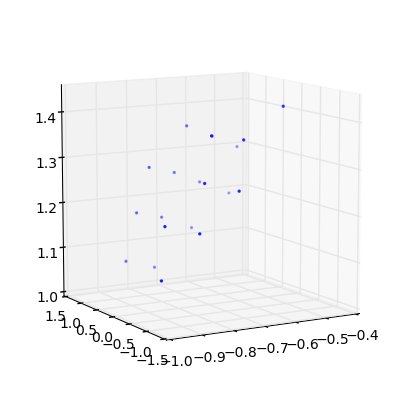

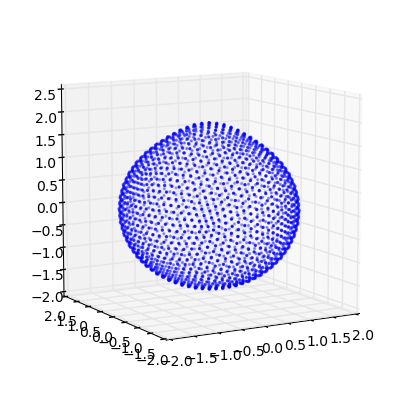

In [48]:
k = 0
# ac = abs(colors[k])
ac = colors[k]
prc = np.percentile(ac, 99)
mask = ac > prc
# plt.plot(sorted())
Point_Cloud(in_pc[k][mask]).plot(in_u_sphere=False);
Point_Cloud(in_pc[k]).plot(in_u_sphere=False);

In [74]:
np.max(abs(colors[k]))

201.2933034799926